In [1]:
import collections
import logging
import os
import pathlib
import re
import string
import sys
import time
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
from keras.preprocessing.text import Tokenizer
#import tensorflow_text as text
import tensorflow as tf
import pandas as pd

from tensorflow import keras
from sklearn.model_selection import train_test_split

In [2]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
data = pd.read_csv("spring/total.csv",encoding='utf-8')

In [4]:
data["categorias"] = data["categorias"].apply(
    lambda x: literal_eval(x)
)

In [5]:
terms = tf.ragged.constant(data["categorias"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)

In [6]:
len(vocab)

32

In [7]:
test_split = 0.2

# Initial train and test split.
train_df, test_df = train_test_split(
    data,
    test_size=test_split,
    stratify=data["categorias"].values,
)

In [8]:
vocabulary = set()
train_df["abstract"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

53929


In [9]:
data["abstract"].apply(lambda x: len(x.split(" "))).describe()

count    18062.000000
mean       112.694995
std         44.707035
min          1.000000
25%         85.000000
50%        110.000000
75%        138.000000
max        852.000000
Name: abstract, dtype: float64

In [10]:
max_seqlen =  138
batch_size = 150
padding_token = "<pad>"
auto = tf.data.AUTOTUNE
max_vocabulary_size = 500
def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["categorias"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["abstract"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [11]:
train_dataset = make_dataset(train_df, is_train=True)
test_dataset = make_dataset(test_df, is_train=False)

In [12]:
text_vectorizer = layers.TextVectorization(
    max_tokens=max_vocabulary_size, ngrams=2, output_mode="multi_hot"
)
with tf.device("/CPU:0"):
    text_vectorizer.adapt(data["abstract"])
train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=max_vocabulary_size,
        output_dim=120,
        mask_zero=True),
    #tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='sigmoid'),
    tf.keras.layers.Dropout(0.5),
    layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
])

In [14]:
model.compile(loss='kullback_leibler_divergence',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy',"binary_accuracy"])

In [15]:
with tf.device("/GPU:0"):
    history = model.fit(train_dataset, epochs=20,
                        validation_data=test_dataset,
                        validation_steps=20)

Epoch 1/20
97/97 [==============================] - 456s 5s/step - loss: 1.6756 - accuracy: 0.0237 - binary_accuracy: 0.4602 - val_loss: 1.3533 - val_accuracy: 0.0050 - val_binary_accuracy: 0.3778
Epoch 2/20
97/97 [==============================] - 468s 5s/step - loss: 1.1990 - accuracy: 0.0400 - binary_accuracy: 0.3410 - val_loss: 0.8926 - val_accuracy: 0.0250 - val_binary_accuracy: 0.2192
Epoch 3/20
97/97 [==============================] - 473s 5s/step - loss: 0.8613 - accuracy: 0.0528 - binary_accuracy: 0.2438 - val_loss: 0.6416 - val_accuracy: 0.0250 - val_binary_accuracy: 0.1329
Epoch 4/20
97/97 [==============================] - 471s 5s/step - loss: 0.6580 - accuracy: 0.0503 - binary_accuracy: 0.1812 - val_loss: 0.4709 - val_accuracy: 0.0250 - val_binary_accuracy: 0.1032
Epoch 5/20
97/97 [==============================] - 476s 5s/step - loss: 0.5077 - accuracy: 0.0493 - binary_accuracy: 0.1411 - val_loss: 0.3502 - val_accuracy: 0.0250 - val_binary_accuracy: 0.0756
Epoch 6/20
97/9

In [16]:
keras.models.save_model(model,'spring/radEd_model_v5.hdf5')
#shallow_mlp_model = tf.keras.models.load_model('spring/radEd_model_v3.hdf5')

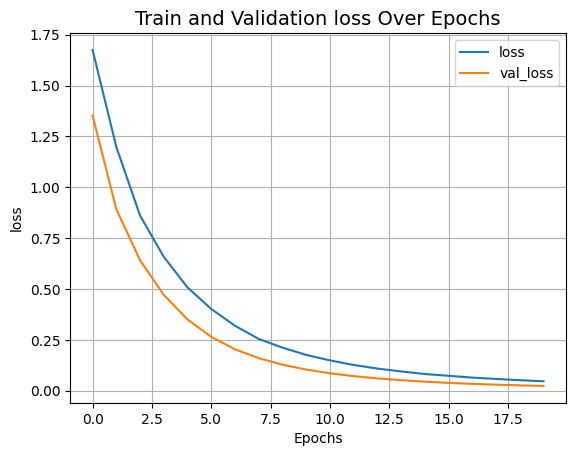

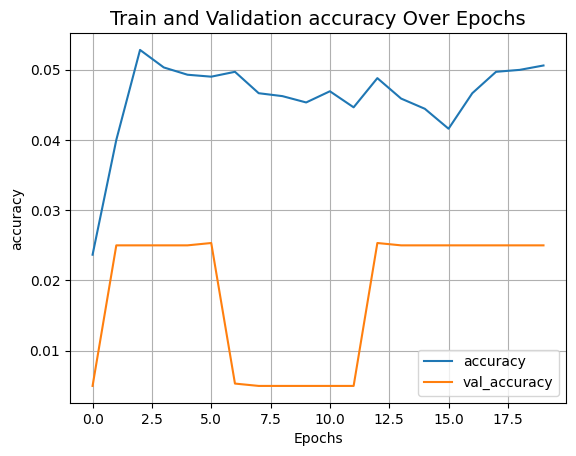

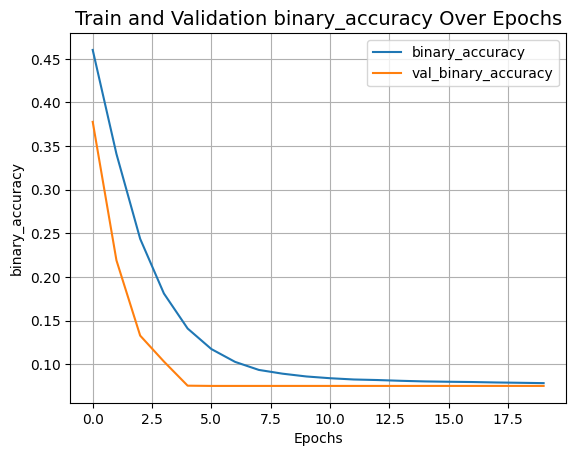

In [17]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")
plot_result("binary_accuracy")

In [18]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:3]):
    label = label_batch[i].numpy()[None, ...]
    #print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_3_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:5]
    print(f"Predicted Label(s): ({', '.join([label for label in top_3_labels])})")
    print(" ")

Label(s): ['Computational Intelligence' 'Data Mining and Knowledge Discovery']
Predicted Label(s): (Cyber-physical systems, IoT, Aerospace Technology and Astronautics, Communications Engineering, Networks, Mechanical Engineering, Artificial Intelligence)
 
Label(s): ['Artificial Intelligence' 'Computer Science'
 'Data Structures and Information Theory']
Predicted Label(s): (Cyber-physical systems, IoT, Aerospace Technology and Astronautics, Communications Engineering, Networks, Mechanical Engineering, Artificial Intelligence)
 
Label(s): ['Medicine & Public Health']
Predicted Label(s): (Cyber-physical systems, IoT, Aerospace Technology and Astronautics, Communications Engineering, Networks, Mechanical Engineering, Artificial Intelligence)
 
